# Loading preprocessed data

In [1]:
import numpy as np
import math
# import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, LearningRateScheduler
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D, Input, MaxPooling2D, Add, GlobalAveragePooling2D, Reshape, Bidirectional, Dense, Flatten, Dropout, SpatialDropout2D
from keras.layers import LSTM, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adadelta
from time import time
from collections import Counter
import matplotlib.pyplot as plt
import os
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix   
import wave
import librosa
import soundfile as sf
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20,7)

2022-05-03 20:19:39.566540: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-03 20:19:39.566565: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
class ResNetLstm():
    """
    Usage: 
        sr = ResNetLstm([4,8,16], input_size=(50,50,1), output_size=12)
        sr.build()
        followed by sr.m.compile(loss='categorical_crossentropy', 
                                 optimizer='adadelta', metrics=["accuracy"])
        save plotted model with: 
            keras.utils.plot_model(sr.m, to_file = '<location>.png', 
                                   show_shapes=True)
    """
    def __init__(self,
                 filters_list=[], 
                 input_size=None, 
                 output_size=None,
                 initializer='glorot_uniform'):
        self.filters_list = filters_list
        self.input_size = input_size
        self.output_size = output_size
        self.initializer = initializer
        self.m = None        
    
    def _block(self, filters, inp):
        """ one residual block in a ResNetLstm
        
        Args:
            filters (int): number of convolutional filters
            inp (tf.tensor): output from previous layer
            
        Returns:
            tf.tensor: output of residual block
        """
        layer_1 = BatchNormalization()(inp)
        act_1 = Activation('relu')(layer_1)
        conv_1 = Conv2D(filters, (3,3), 
                        padding = 'same', 
                        kernel_initializer = self.initializer)(act_1)
        layer_2 = BatchNormalization()(conv_1)
        act_2 = Activation('relu')(layer_2)
        conv_2 = Conv2D(filters, (3,3), 
                        padding = 'same', 
                        kernel_initializer = self.initializer)(act_2)
        return(conv_2)
    def build(self):
        """
        Returns:
            keras.engine.training.Model
        """

        print('1shapes: ', self.input_size)
        i = Input(shape = self.input_size, name = 'input')
        x = Conv2D(self.filters_list[0], (3,3), 
                   padding = 'same',
                   kernel_initializer = self.initializer)(i)
        print('2shapes: ', x.shape)
        x = MaxPooling2D((1,3))(x)
        # x = MaxPooling2D(padding = 'same')(x)
        print('3shapes: ', x.shape)
        x = Add()([self._block(self.filters_list[0], x),x])
        x = Add()([self._block(self.filters_list[0], x),x])
        x = Add()([self._block(self.filters_list[0], x),x])
        if len(self.filters_list) > 1:
            for filt in self.filters_list[1:]:
                print(filt)
                x = Conv2D(filt, (3,3),
                           strides = (1,1),
                           padding = 'same',
                           activation = 'relu',
                           kernel_initializer = self.initializer)(x)
                x = MaxPooling2D((1,3))(x)
                print('6shapes: ', x.shape)
                x = Add()([self._block(filt, x),x])
                x = Add()([self._block(filt, x),x])
                x = Add()([self._block(filt, x),x])
        # x = GlobalAveragePooling2D()(x)
        
        x = Reshape((85,4*32))(x)
        print('7shapes: ', x.shape)
        x = Bidirectional(LSTM(64,return_sequences=True))(x)
        print('8shapes: ', x.shape)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Bidirectional(LSTM(32,return_sequences=True))(x)
        print('9shapes: ', x.shape)
        x = Reshape((85,2*32))(x)
        print('0shapes: ', x.shape)
        print('output_size: ', self.output_size)
        x = Flatten()(x)
        print('1shapes: ', x.shape)
        x = Dropout(0.2)(x)
        
        x = Dense(self.output_size, activation = 'softmax')(x)
        print('2shapes: ', x.shape)
        
        self.m = Model(i,x)
        return self.m

In [3]:
# temporarely unused
def load_wave(filename):
   # Read file to get buffer                                                                                               
   ifile = wave.open(filename)
   samples = ifile.getnframes()
   audio = ifile.readframes(samples)

   # Convert buffer to float32 using NumPy                                                                                 
   audio_as_np_int16 = np.frombuffer(audio, dtype=np.int16)
   audio_as_np_float32 = audio_as_np_int16.astype(np.float32)

   # Normalise float32 array so that values are between -1.0 and +1.0                                                      
   max_int16 = 2**15
   audio_normalised = audio_as_np_float32 / max_int16
   return audio_normalised

### import training and validation data (not included in repo)

In [4]:
# path = '/home2/faculty/kmrozowski/rl2/wut-mini-deep-learning/speech-recognition/'
path = '/home/metiulekm/wut-mini-deep-learning/speech-recognition/'
X_train = np.load(path+'data/X_train.npy').transpose((0,2,1,3))
Y_train = np.load(path+'data/Y_train.npy')
X_val = np.load(path+'data/X_val.npy').transpose((0,2,1,3))
Y_val = np.load(path+'data/Y_val.npy')

In [5]:
X_train_flipped = np.flip(X_train, 2)
Y_train_flipped = Y_train
Y_train_flipped[Y_train != 10] = 11
X_train = np.append(X_train, X_train_flipped, 0)
Y_train = np.append(Y_train, Y_train_flipped)

In [6]:
X_train.shape
# (58284, 122, 85, 1) -> (n_samples, frequencies, timestamps, 1)

(116568, 85, 122, 1)

In [7]:
Y_train.shape

(116568,)

In [8]:
#path = '/home/metiulekm/wut-mini-deep-learning/speech-recognition/'
path = '/dev/shm/kmrozowski/'
classes = ['yes', 'no', 
           'up', 'down', 
           'left', 'right', 
           'on', 'off', 
           'stop', 'go', 
           'silence', 'unknown']
all_classes = [x for x in classes[:11]]
for ind, cl in enumerate(os.listdir(path + 'data/train/audio/')):
    if cl not in classes:
        all_classes.append(cl)
classes_binary = ['known', 'unknown']
classes_known = classes[:-1]
print(all_classes, '-->', classes_binary, '-->', classes_known)

['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'bed', 'bird', 'cat', 'dog', 'eight', 'five', 'four', 'happy', 'house', 'marvin', 'nine', 'one', 'seven', 'sheila', 'six', 'three', 'tree', 'two', 'wow', 'zero'] --> ['known', 'unknown'] --> ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence']


In [9]:
def binarize_classes(set):
   for i, class_idx in enumerate(set):
      if classes[class_idx] == 'unknown':
         set[i] = 1
      else:
         set[i] = 0
Y_train_binary = Y_train.copy()
Y_val_binary = Y_val.copy()
binarize_classes(Y_train_binary)
binarize_classes(Y_val_binary)

In [10]:
# for label in all_classes:
#    print(data[label].shape, ':)')

### The training data is very unbalanced with a much larger 'unknown' class. Keras has a class_weight paramter in the fit() function that will give higher penalties to missclassifications in underrepresented classes. It takes a dict like this:

In [11]:
def get_class_weights(y):
   counter = Counter(y)
   majority = max(counter.values())
   return  {cls: float(majority/count) for cls, count in counter.items()}  

class_weights_binary = get_class_weights(Y_train_binary)
class_weights_binary


{1: 1.0, 0: 160.45152354570638}

some constants we need for all models

In [12]:
input_size = X_train.shape[1:]
batch_size = 196

## The ResNet
### declare filters for each block of blocks and set output size.

In [13]:
filters_list = [8,16,32]
output_size_binary = 2

In [14]:
#adjust these strings for organizeing the saved files
date = '20220502'
arch = 'resnetlstm8_16_32_128_binary'

### Build the model

In [15]:
sr = ResNetLstm(filters_list, input_size, output_size_binary)
sr.build()
sr.m.compile(loss='categorical_crossentropy', 
             optimizer=Adadelta(learning_rate=1.0,
                                rho=0.95,
                                epsilon=1e-07,
                                name="Adadelta"),
             metrics=['accuracy'])

1shapes:  (85, 122, 1)
2shapes:  (None, 85, 122, 8)
3shapes:  (None, 85, 40, 8)
16
6shapes:  (None, 85, 13, 16)
32
6shapes:  (None, 85, 4, 32)


2022-05-03 20:19:46.733239: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-03 20:19:46.733260: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-03 20:19:46.733274: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (blue): /proc/driver/nvidia/version does not exist
2022-05-03 20:19:46.733405: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


7shapes:  (None, 85, 128)
8shapes:  (None, 85, 128)
9shapes:  (None, 85, 64)
0shapes:  (None, 85, 64)
output_size:  2
1shapes:  (None, 5440)
2shapes:  (None, 2)


In [16]:
sr.m.summary()
# Total params: 80,540
# Trainable params: 79,868
# Non-trainable params: 672

# Total params: 286,748
# Trainable params: 285,820
# Non-trainable params: 928

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 85, 122, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 85, 122, 8)   80          ['input[0][0]']                  
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 85, 40, 8)    0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 85, 40, 8)   32          ['max_pooling2d[0][0]']      

 rmalization)                                                                                     
                                                                                                  
 activation_8 (Activation)      (None, 85, 13, 16)   0           ['batch_normalization_8[0][0]']  
                                                                                                  
 conv2d_10 (Conv2D)             (None, 85, 13, 16)   2320        ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 85, 13, 16)  64          ['conv2d_10[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 activation_9 (Activation)      (None, 85, 13, 16)   0           ['batch_normalization_9[0][0]']  
          

 conv2d_20 (Conv2D)             (None, 85, 4, 32)    9248        ['activation_17[0][0]']          
                                                                                                  
 add_8 (Add)                    (None, 85, 4, 32)    0           ['conv2d_20[0][0]',              
                                                                  'add_7[0][0]']                  
                                                                                                  
 reshape (Reshape)              (None, 85, 128)      0           ['add_8[0][0]']                  
                                                                                                  
 bidirectional (Bidirectional)  (None, 85, 128)      98816       ['reshape[0][0]']                
                                                                                                  
 batch_normalization_18 (BatchN  (None, 85, 128)     512         ['bidirectional[0][0]']          
 ormalizat

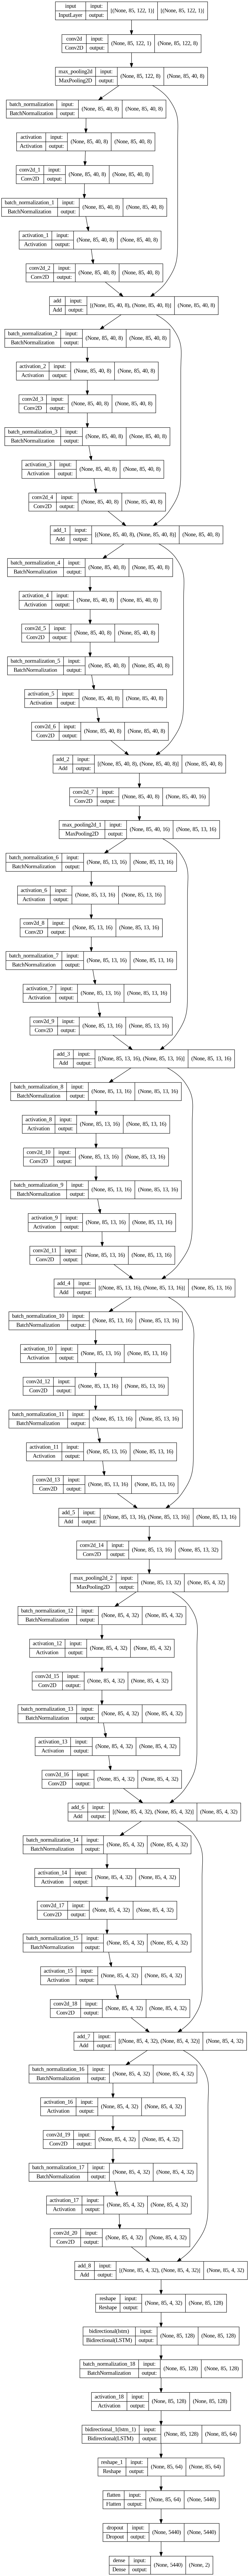

In [17]:
# to save a png of the model you need pydot and graphviz installed
plot_model(sr.m,
           to_file = './models/{}_{}.png'.format(arch,date), 
           show_shapes = True)

In [18]:
def step_decay(epoch):
   initial_lrate = 0.4
   # drop = 0.5
   # epochs_drop = 10.0
   fastest_decay_epicentrum = 70
   epochs_of_fast_decaying = 18
   lrate = initial_lrate * (math.atan(-(epoch-fastest_decay_epicentrum)/epochs_of_fast_decaying) + 0.915 * math.pi/2) * 0.34
   # lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
   return lrate

#callbacks, remember to make folders to store files 
checkpointer = ModelCheckpoint(filepath='./models/{}_{}_best.h5'.format(arch, date),
                               verbose=0,
                               save_best_only=True)
   
earlystopping = EarlyStopping()

tensorboard = TensorBoard(log_dir = './logs/{}_{}'.format(date, time()), 
                          histogram_freq = 0, 
                          write_graph = True, 
                          write_images = True)
sheluder = LearningRateScheduler(step_decay, verbose=0)

In [19]:
def step_decay(epoch):
   initial_lrate = 0.4
   # drop = 0.5
   # epochs_drop = 10.0
   fastest_decay_epicentrum = 600
   epochs_of_fast_decaying = 200
   lrate = initial_lrate * (math.atan(-(epoch-fastest_decay_epicentrum)/epochs_of_fast_decaying) + 0.915 * math.pi/2) * 0.34
   # lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
   return lrate

#callbacks, remember to make folders to store files 
checkpointer = ModelCheckpoint(filepath='./models/{}_{}_best.h5'.format(arch, date),
                               verbose=0,
                               save_best_only=True)
   
earlystopping = EarlyStopping()

tensorboard = TensorBoard(log_dir = './logs/{}_{}'.format(date, time()), 
                          histogram_freq = 0, 
                          write_graph = True, 
                          write_images = True)
sheluder = LearningRateScheduler(step_decay, verbose=0)

v = np.arange(1,200,1)
w = [step_decay(x) for x in v]
print(w[-1])

0.346177849024205


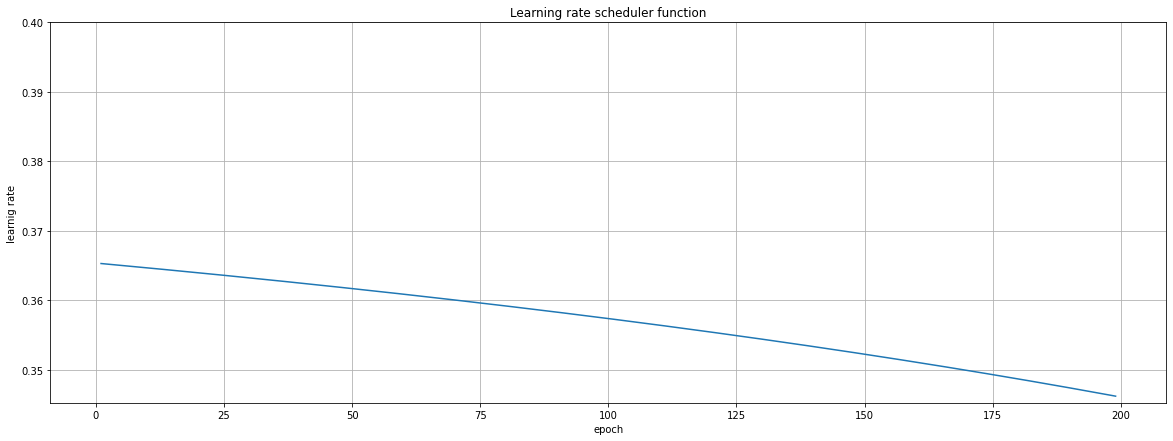

In [20]:
plt.plot(v,w)
plt.title('Learning rate scheduler function')
plt.xlabel('epoch')
plt.ylabel('learnig rate')
plt.ylim(top=0.4)
plt.grid()
plt.show()

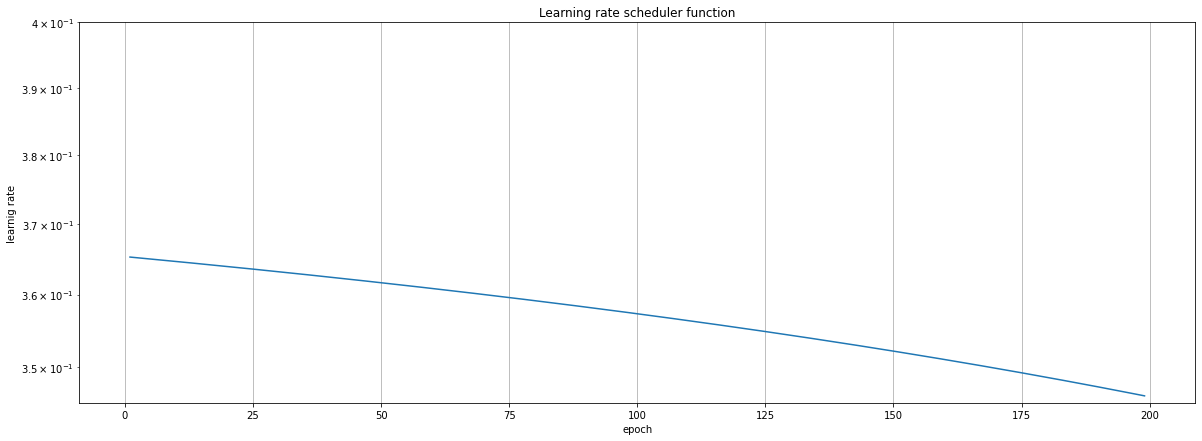

In [21]:
plt.plot(v,w)
plt.title('Learning rate scheduler function')
plt.xlabel('epoch')
plt.ylabel('learnig rate')
plt.yscale('log')
plt.ylim(top=0.4)
plt.grid()
plt.show()

### Load model weights (optional)

In [67]:
!ls /home2/faculty/kmrozowski/models/

resnetlstm8_16_32_128_20220430_best.h5
resnetlstm8_16_32_128_20220431_best.h5
resnetlstm8_16_32_128_binary_20220431_best.h5


In [173]:
path = '/home2/faculty/kmrozowski/models/'
sr.m.load_weights(path + 'resnetlstm8_16_32_128_binary_20220431_best.h5')

### Train the model. The history object stores training data for later access, like plotting training curves

In [22]:
history = sr.m.fit(X_train, 
                   to_categorical(Y_train_binary),
                   batch_size = batch_size,
                   epochs = 1000,
                   verbose = 1, shuffle = True, 
                   class_weight = class_weights_binary,
                   validation_data = (X_val, to_categorical(Y_val_binary)), 
                   callbacks = [checkpointer, tensorboard, sheluder]) # add more callbacks if you want

2022-05-03 20:19:54.202317: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4835240640 exceeds 10% of free system memory.


Epoch 1/3
595/595 [==============================] - 582s 969ms/step - loss: 0.0938 - accuracy: 0.9880 - val_loss: 2.8237 - val_accuracy: 0.6230 - lr: 0.3653
Epoch 2/3
595/595 [==============================] - 574s 965ms/step - loss: 0.0305 - accuracy: 0.9976 - val_loss: 4.1124 - val_accuracy: 0.6233 - lr: 0.3653
Epoch 3/3
166/595 [=======>......................] - ETA: 6:50 - loss: 0.0087 - accuracy: 0.9987

KeyboardInterrupt: 

In [ ]:
sr.m.save_weights("./models/{}_{}_last.h5".format(arch, date)) 

### Plot the training graphs, and save them

In [ ]:
#%% visualize training
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('graphs/{}_{}_acc.png'.format(arch, date),bbox_inches='tight')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('graphs/{}_{}_loss.png'.format(arch, date), bbox_inches='tight')
plt.show()

### Predict the validation classification and score

In [ ]:
val_pred = sr.m.predict(X_val, batch_size = batch_size, verbose = 1)

In [ ]:
print(classification_report(Y_val_binary, np.argmax(val_pred, axis = 1), target_names = classes_binary, digits = 3))

In [ ]:
print(confusion_matrix(Y_val_binary, np.argmax(val_pred, axis = 1)))
# [[1973  645]
#  [ 460 3761]]

In [ ]:
cf_mat = confusion_matrix(Y_val_binary, np.argmax(val_pred, axis = 1))
b = cf_mat.copy()
sum = 0.0
sum_diag = 0.0
for i in range(cf_mat.shape[0]):
   for j in range(cf_mat.shape[0]):
      if j != i:
         sum += cf_mat[i][j]
      else:
         sum_diag += cf_mat[i][j]
acc = sum_diag / (sum + sum_diag)
print('acc =', acc)

In [ ]:
ax = sns.heatmap(cf_mat, annot=cf_mat, fmt='', cmap='Blues', vmin=0, vmax=4000)
ax.set_title('ResNet-2xCuDNNLSTM-lr1.0\n\n')
ax.set_xlabel('\nPredicted class')
ax.set_ylabel('Actual class')
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(classes_binary)
ax.yaxis.set_ticklabels(classes_binary)
plt.show()

### convert spectrogram to audio (doesn't work D: )

In [ ]:
errors_path = '/home2/faculty/kmrozowski/rl2/wut-mini-deep-learning/speech-recognition/data/errors/'
for actual_label in range(cf_mat.shape[0]):
   for predicted_label in range(cf_mat.shape[1]):
      err_name = classes[actual_label] + '_' + classes[predicted_label]
for i, (x, actual_label, predicted_label) in enumerate(zip(X_val, Y_val, np.argmax(val_pred, axis = 1))):
   if i < 1000:
      continue
   if actual_label != predicted_label:
      if classes[actual_label] == 'unknown' or classes[predicted_label] == 'unknown':
         continue
      err_name = classes[actual_label] + '_' + classes[predicted_label]
      if not os.path.exists(errors_path + err_name):
            os.makedirs(errors_path + err_name)
      # audio_signal = librosa.feature.inverse.mel_to_audio(x.transpose([1,0,2])[:,:,0], sr=16000)
      audio_signal = librosa.core.spectrum.griffinlim(x.transpose([1,0,2])[:,:,0])
      print(classes[actual_label] + ' != ' + classes[predicted_label], x.transpose([1,0,2]).shape, i, audio_signal.shape)
      output_path = errors_path + err_name + '/error_' + str(i) + '.wav'
      sf.write(output_path, audio_signal, 16000, format='wav')
      plt.plot(audio_signal)
      break

   

### Divide validation/train set into knowns and unknowns

In [ ]:
def binary_to_known(X, Y, Y_binary, label, labels):
   X_label = []
   Y_label = []
   for x, y, y_binary in zip(X, Y, Y_binary):
      if labels[y_binary] == label:
         X_label.append(x)
         Y_label.append(y)
   return (np.array(X_label), np.array(Y_label))

X_train_known, Y_train_known = binary_to_known(X_train, Y_train, Y_train_binary, 'known', classes_binary)
X_val_known, Y_val_known = binary_to_known(X_val, Y_val, Y_val_binary, 'known', classes_binary)

# The real ResNet

In [ ]:
class_weights_known = get_class_weights(Y_train_known)
class_weights_known

In [ ]:
#filters_size should not change
output_size = 11
arch = 'resnetlstm8_16_32_128_secondary'

In [ ]:
sr2 = ResNetLstm(filters_list, input_size, output_size)
sr2.build()
sr2.m.compile(loss='categorical_crossentropy', 
             optimizer=Adadelta(learning_rate=1.0,
                                rho=0.95,
                                epsilon=1e-07,
                                name="Adadelta"),
             metrics=['accuracy'])

In [ ]:
sr2.m.summary()

In [ ]:
plot_model(sr2.m,
           to_file = './models/{}_{}.png'.format(arch,date), 
           show_shapes = True)

In [ ]:
# Copy the weights for all but last layer.
for i in range(len(sr.m.layers) - 1):
    sr2.m.layers[i].set_weights(sr.m.layers[i].get_weights())
for i in range(len(sr2.m.layers) - 7):
    sr2.m.layers[i].trainable = False
sr2.m.compile(loss='categorical_crossentropy', 
             optimizer=Adadelta(learning_rate=1.0,
                                rho=0.95,
                                epsilon=1e-07,
                                name="Adadelta"),
             metrics=['accuracy'])

In [ ]:
history = sr2.m.fit(X_train_known, 
                   to_categorical(Y_train_known), 
                   batch_size = batch_size,
                   epochs = 30,
                   #epochs = 3,
                   verbose = 1, shuffle = True,
                   class_weight = class_weights_known,
                   validation_data = (X_val_known, to_categorical(Y_val_known)), 
                   callbacks = [checkpointer, tensorboard, sheluder]) # add more callbacks if you want

In [ ]:
for i in range(len(sr2.m.layers) - 7):
    sr2.m.layers[i].trainable = True
sr2.m.compile(loss='categorical_crossentropy', 
             optimizer=Adadelta(learning_rate=1.0,
                                rho=0.95,
                                epsilon=1e-07,
                                name="Adadelta"),
             metrics=['accuracy'])

In [ ]:
def step_decay(epoch):
   initial_lrate = 0.4
   fastest_decay_epicentrum = 1000
   epochs_of_fast_decaying = 250
   lrate = initial_lrate * (math.atan(-(epoch-fastest_decay_epicentrum)/epochs_of_fast_decaying) + 0.922 * math.pi/2) * 0.34
   # lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
   return lrate

#callbacks, remember to make folders to store files 
checkpointer = ModelCheckpoint(filepath='./models/{}_{}_best.h5'.format(arch, date),
                               verbose=0,
                               save_best_only=True)
   
earlystopping = EarlyStopping()

tensorboard = TensorBoard(log_dir = './logs/{}_{}'.format(date, time()), 
                          histogram_freq = 0, 
                          write_graph = True, 
                          write_images = True)
sheluder = LearningRateScheduler(step_decay, verbose=0)

v = np.arange(1,3000,1)
w = [step_decay(x) for x in v]
print(w[-1])

In [ ]:
plt.plot(v,w)
plt.title('Learning rate scheduler function')
plt.xlabel('epoch')
plt.ylabel('learnig rate')
plt.ylim(top=0.6)
plt.grid()
plt.show()

In [ ]:
history = sr2.m.fit(X_train_known, 
                   to_categorical(Y_train_known), 
                   batch_size = 64,
                   epochs = 3000,
                   #epochs = 3,
                   verbose = 1, shuffle = True, 
                   class_weight = class_weights_known,
                   validation_data = (X_val_known, to_categorical(Y_val_known)), 
                   callbacks = [checkpointer, tensorboard, sheluder]) # add more callbacks if you want
# 4 -> 100, 18 -> 249

In [ ]:
sr.m.save_weights("./models/{}_{}_last.h5".format(arch, date))

In [ ]:
#%% visualize training
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('graphs/{}_{}_acc.png'.format(arch, date),bbox_inches='tight')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('graphs/{}_{}_loss.png'.format(arch, date), bbox_inches='tight')
plt.show()

In [ ]:
val_pred_known = sr2.m.predict(X_val_known, batch_size = batch_size, verbose = 1)

In [ ]:
print(classification_report(Y_val_known, np.argmax(val_pred_known, axis = 1), target_names = classes_known, digits = 3))

In [ ]:
print(confusion_matrix(Y_val_known, np.argmax(val_pred_known, axis = 1)))
# Before separate network for unknowns:
# [[ 231    4    0    9    0    0    1    0    4    4    1    7]
#  [   0  170    0   21    0    0    0    0    2   69    0    8]
#  [   0    0  203    1    0    0    5    1   39    6    2    3]
#  [   0    4    0  245    0    0    0    0    3   11    0    1]
#  [  11    5    0    7  192    0    1    0   14    8    1    8]
#  [   0    1    1    0    4  213    8    0    2    6    0   21]
#  [   0    0    2    1    0    0  247    1    1    1    3    1]
#  [   0    0   11    0    0    0   46  177   15    4    0    3]
#  [   1    0    0    5    0    0    1    0  230    6    1    2]
#  [   0    1    1   13    0    0    2    2    3  231    5    2]
#  [   0    0    0    0    0    0    0    0    0    0   41    0]
#  [   9   32   25  321   13   19  321   10  125  322   18 3006]]
#After:

In [ ]:
cf_mat = confusion_matrix(Y_val_known, np.argmax(val_pred_known, axis = 1))
b = cf_mat.copy()
sum = 0.0
sum_diag = 0.0
for i in range(cf_mat.shape[0]):
   for j in range(cf_mat.shape[0]):
      if j != i:
         sum += cf_mat[i][j]
      else:
         sum_diag += cf_mat[i][j]
acc = sum_diag / (sum + sum_diag)
print('acc =', acc)

In [ ]:
ax = sns.heatmap(cf_mat, annot=cf_mat, fmt='', cmap='Blues', vmin=0, vmax=250)
ax.set_title('ResNet-2xCuDNNLSTM-lr1.0\n\n')
ax.set_xlabel('\nPredicted class')
ax.set_ylabel('Actual class')
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(classes_known)
ax.yaxis.set_ticklabels(classes_known)
plt.show()